In [3]:
# IMPORTING MODULES

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, average_precision_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# GOOGLE COLAB SETUP

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 1. Importing Data

train = pd.read_csv('/content/drive/MyDrive/SJ-DECEN_code/data/train_cleaned_no_punkt.csv')
test_labelled = pd.read_csv('/content/drive/MyDrive/SJ-DECEN_code/data/test_labelled_cleaned_no_punkt.csv')
test_unlabelled = pd.read_csv('/content/drive/MyDrive/SJ-DECEN_code/data/test_unlabelled_cleaned_no_punkt.csv')

In [6]:
# 2. Create 'mal' label (1 if any toxic label is 1)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['mal'] = train[label_cols].sum(axis=1) >= 1
test_labelled['mal'] = test_labelled[label_cols].sum(axis=1) >= 1

In [7]:
# 3. Drop old label columns and fill NaNs
train.drop(columns=label_cols, inplace=True)
test_labelled.drop(columns=label_cols, inplace=True)
train['comment_text'].fillna("empty", inplace=True)
test_labelled['comment_text'].fillna("empty", inplace=True)
test_unlabelled['comment_text'].fillna("empty", inplace=True)

In [ ]:
# 4. Stratified splitting and combining for balanced training
rs = 42
X_train1, X_test1, y_train1, y_test1 = train_test_split(train['comment_text'], train['mal'], test_size=0.29, stratify=train['mal'], random_state=rs)
X_train2, X_test2, y_train2, y_test2 = train_test_split(test_labelled['comment_text'], test_labelled['mal'], test_size=0.29, stratify=test_labelled['mal'], random_state=rs)

X_train = np.concatenate([X_train1.values, X_train2.values])
y_train = np.concatenate([y_train1.values, y_train2.values])
X_test = np.concatenate([X_test1.values, X_test2.values])
y_test = np.concatenate([y_test1.values, y_test2.values])

In [ ]:
# 5. Tokenization and Padding
vocab_size = 20000
max_len = 150
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [ ]:
# 6. Model building
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# 7. Training
history = model.fit(X_train_pad, y_train, validation_split=0.2, epochs=5, batch_size=64)


Epoch 1/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 474s 237ms/step - accuracy: 0.8970 - loss: 0.3565 - val_accuracy: 0.9033 - val_loss: 0.3154
Epoch 2/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 507s 240ms/step - accuracy: 0.9067 - loss: 0.3006 - val_accuracy: 0.9404 - val_loss: 0.1467
Epoch 3/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 490s 233ms/step - accuracy: 0.9590 - loss: 0.1158 - val_accuracy: 0.9390 - val_loss: 0.1465
Epoch 4/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 515s 240ms/step - accuracy: 0.9674 - loss: 0.0886 - val_accuracy: 0.9360 - val_loss: 0.1656
Epoch 5/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 497s 238ms/step - accuracy: 0.9764 - loss: 0.0620 - val_accuracy: 0.9245 - val_loss: 0.2233


In [ ]:
# 8. Evaluation
predictions = model.predict(X_test_pad).flatten()
predictions_bin = (predictions > 0.5).astype("int32")

accuracy = accuracy_score(y_test, predictions_bin)
class_report = classification_report(y_test, predictions_bin)
avg_precision = average_precision_score(y_test, predictions)


2026/2026 ━━━━━━━━━━━━━━━━━━━━ 57s 28ms/step


In [ ]:
# 9. Output
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{class_report}')
print(f'Average Precision: {avg_precision}')

Accuracy: 0.9488662656177695
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.97      0.97     58314
        True       0.73      0.78      0.75      6516

    accuracy                           0.95     64830
   macro avg       0.85      0.87      0.86     64830
weighted avg       0.95      0.95      0.95     64830

Average Precision: 0.8254309385708222


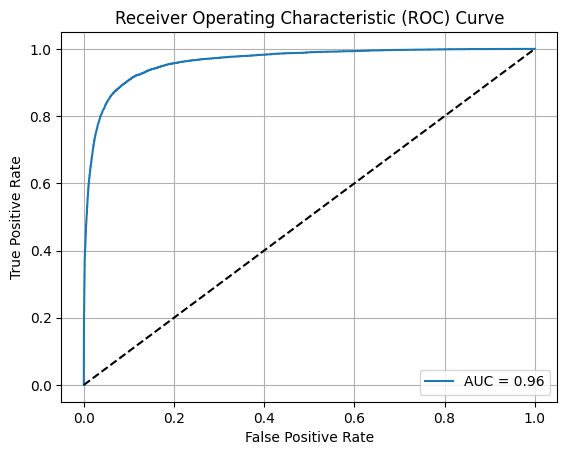

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
